# Data And torch.utils.data

## Intro to DataLoader

Data manipulation and model/training may seem separable; however, it is often not the case. Before we dive into model construction or training, we need to first make decisions on how our (text) data -- possibly saved in one or multiple files -- should be read and processed.\
\
Let's first look at this <code>train_epoch</code> function from PyTorch's documentation. (Extracted 2023/01/06)\
\
We can see here that a <code>torch.utils.data.DataLoader</code> object is created with some kind of a data iterator, batch size, and a collate function.\
According to PyTorch's <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'>documentation</a>, <code>DataLoader</code> class is at the heart of PyTorch data loading utility. It is useful for batching, customizing data sampling, parallelizing data loading, and fast data transfer with memory pinning.\
\
It seems complicated already, but essentially, a <code>DataLoader</code> is just an iterator that gives you a processed <strong>batch</strong> each time from your actual data. With that in mind, we can continue to see what we need to construct a <code>DataLoader</code> for machine translation task.
<p style="text-align:center;"><img src='./images/train_epoch_codesnippet.png' style='max-width: 50%; height: auto;'></p>


## Dataset

A <code>dataset</code> is the most important argument of <code>DataLoader</code> constructor. The <code>dataset</code> object is not your actual data, rather, it should be seen as a Python object created with the actual data or the path to your data.\
\
<code>torch.utils.data.DataLoader</code> supports two types of datasets. Either way, we need to write our own <code>dataset</code> class.
<ul>
    <li>map-style dataset: an instance of a subclass of <code>torch.utils.data.Dataset</code></li>
    <li>iterable-style dataset: an instance of a subclass of <code>torch.utils.data.IterableDataset</code></li>
</ul>
More detail see PyTorch's <a href='https://pytorch.org/docs/stable/data.html#dataset-types'>documentation.</a>

For this notebook, we have file based data saved on local disk. Since I do not want to load all the data into the memory at once, I choose to create a iterable-styple dataset.\
\
When subclassing <code>torch.utils.data.IterableDataset</code>, it is required to implement custom <code>\_\_iter\_\_</code> function. I highly recommend reading this <a href='https://medium.com/swlh/how-to-use-pytorch-dataloaders-to-work-with-enormously-large-text-files-bbd672e955a0'>article</a> on subclassing <code>IterableDataset</code>.\
\
Our data consists of tab-separated source target bitext per line, so we all do some processing when reading each line, hence the <code>def _line_split</code> and the leverage of <code>map()</code>.

In [1]:
from torch.utils.data import IterableDataset

class MyIterableDataset(IterableDataset):
    def __init__(self, file_path):
        self.file_path = file_path
        
    def _line_split(self, line):
        src, tgt = line.strip('\n').split('\t')
        return src, tgt
    
    def __iter__(self):
        file_iter = open(self.file_path, 'r', encoding='utf-8')
        mapped_iter = map(self._line_split, file_iter)
        return mapped_iter

In [4]:
train_iter = MyIterableDataset('./data/train')

#### little test on MyIterableDataset

In [5]:
for pair in train_iter:
    print(pair)
    break

('this is a test', '这是个测试')


## Collate function

The second building block of a <code>DataLoader</code> is <code>collate_fn</code>. Basically, <code>collate_fn</code> is a callable that takes in a raw batch (with typing as <code>List</code>) of return results from <code>dataset</code> as argument and transform it into desired output format.\
\
You can do some processing on the raw batch and also define how you want to create your batch. If not defined, PyTorch only put <code>batch_size</code> examples together using <code>torch.stack</code>.\
\
In our case, <code>dataset</code> is only returning a tuple of raw string <code>(src, tgt)</code>, which we cannot directly pass into a <em>transformer</em> model. We still need:
<ul>
    <li>tokenization</li>
    <li>numericalization</li>
    <li>adding BOS and EOS token</li>
    <li>padding: we cannot make batch if tensors' length is not the same</li>
</ul>

#### tokenization and numericalization (torchtext.vocab.Vocab)

In [ ]:
# I already trained the tokenizers with SentencePiece
import sentencepiece as spm

src_tokenizer = spm.SentencePieceProcessor(model_file='./tokenizer/tokenizer_sp_en')
tgt_tokenizer = spm.SentencePieceProcessor(model_file='./tokenizer/tokenizer_sp_zh')

Numericalization depends on creating a <code>torchtext.vocab.Vocab</code> object. See <a href='https://pytorch.org/text/0.14.0/vocab.html'>Documentation</a>.\
\
Two major methods to build the <code>Vocab</code>:
<ul>
    <li>factory method from a <code>Ordered Dictionary</code> which maps tokens to occurance frequencies</li>
    <li>build_vocab_from_iterator</li>
</ul>

In [ ]:
""" factory method, only as an example """

from collections import Counter

def build_vocab(text, index, tokenizer):
  counter = Counter()
  for s in text:
    counter.update(tokenizer.encode(s, out_type=str))
  return vocab(counter, min_freq=10, specials=special_symbols)

In [ ]:
# since we already created the train_iter, we will use this method
from torchtext.vocab import build_vocab_from_iterator

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

def yield_tokens(bitext_iter, is_src: bool):
    for bitext in bitext_iter:
        if is_src:
            yield src_tokenizer.encode(bitext[0], out_type=str)
        else:
            yield tgt_tokenizer.encode(bitext[1], out_type=str)

src_vocab = build_vocab_from_iterator(yield_tokens(train_iter, is_src=True),
                                     min_freq=10,
                                     specials=special_symbols,
                                     special_first=True)
tgt_vocab = build_vocab_from_iterator(yield_tokens(train_iter, is_src=False),
                                     min_freq=10,
                                     specials=special_symbols,
                                     special_first=True)

#### little test on Vocab objects

In [6]:
src_vocab.lookup_token(45)

'▁or'

In [7]:
src_vocab.lookup_token(1)

'<pad>'

In [8]:
tgt_vocab.lookup_token(394)

'奢华'

In [9]:
tokenized = src_tokenizer.encode('transformer is a Seq2Seq model introduced in “attention is all you need” paper for solving machine translation tasks.', out_type=str)
print(tokenized)
src_vocab(tokenized)

['▁transform', 'er', '▁is', '▁a', '▁Se', 'q', '2', 'Se', 'q', '▁model', '▁introduced', '▁in', '▁“', 'att', 'ention', '▁is', '▁all', '▁you', '▁need', '”', '▁paper', '▁for', '▁sol', 'ving', '▁machine', '▁translation', '▁tasks', '.']


[4099,
 509,
 18,
 11,
 3828,
 5650,
 19,
 14670,
 5650,
 145,
 1479,
 12,
 71,
 5275,
 17046,
 18,
 61,
 34,
 456,
 108,
 1559,
 20,
 7974,
 7404,
 2409,
 16672,
 4287,
 6]

#### set default index for OOV token
We also need to assign default token index for OOV token, which should be the index of <unk> in this case (and many other cases).

In [ ]:
src_vocab.set_default_index(0)
tgt_vocab.set_default_index(0)

#### Now we can finally create our collate function.

In [9]:
import torch
from torch.nn.utils.rnn import pad_sequence
from typing import List, Tuple

def collate_fn(paired_batch: List[Tuple[str]]):
    src_batch = []
    tgt_batch = []
    for src, tgt in paired_batch:
        # tokenization and numericalization
        src = src_vocab(src_tokenizer.encode(src, out_type=str))
        tgt = tgt_vocab(tgt_tokenizer.encode(tgt, out_type=str))
        # adding BOS and EOS token
        src = torch.cat((torch.tensor([BOS_IDX]),
                         torch.tensor(src),
                         torch.tensor([EOS_IDX])))
        tgt = torch.cat((torch.tensor([BOS_IDX]),
                         torch.tensor(tgt),
                         torch.tensor([EOS_IDX])))
        src_batch.append(src)
        tgt_batch.append(tgt)
    # padding
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

## Create DataLoader

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_iter, batch_size=10, collate_fn=collate_fn)

A little test on the return result of our dataloader.\
Note how the padding is done __vertically__. Each column of the 2-dimensional matrix is a sentence (either source or target).

In [11]:
for src_batch, tgt_batch in train_dataloader:
    print(src_batch)
    print(tgt_batch)
    break

tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2],
        [   29,   216,    20,    41, 27230,    50,    11,   163,  1106,  3211],
        [   18,  1740,    29,    18,   782,   534,  1200,   234,   503,  7850],
        [   11,    13,   166,    38,  1309,  9652,    32, 21288,   188, 24129],
        [  785,  2535,     5,  2617,  1958,    15,    63,  9523,  2085,   326],
        [    3,   571,     4,   819,   821,    50,   172,  4065,   377,     3],
        [    1,     3,  3461,    13,  1221,    44,  6958,   234,   436,     1],
        [    1,     1,    63, 12957,     4,  1053,  8456,  5249,  7664,     1],
        [    1,     1, 16195,  2911,     7,     3,  2930, 13536,   369,     1],
        [    1,     1,  1733,    12,    16,     1,    30,    36,     3,     1],
        [    1,     1,  3891,  5605,     5,     1,   500,     8,     1,     1],
        [    1,     1,  6807,  9401,    33,     1,     6,   163,     1,     1],
        [    1,     1,     8,    13,    

# Build <i>transformer</i> model for MT

I will first give out the whole model code then explain some details that might be necessary or helpful. The major part of PyTorch's model codes are usually quite self-explanatory.

In [12]:
# due to demonstration need, especially for explaning masking later, I will need to define 'DEVICE' first in this notebook.

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model code

I maninly copied the code from PyTorch's <a href='https://pytorch.org/tutorials/beginner/translation_transformer.html'>tutorial</a>, with a few modifications.

The most important change I've made is that I deleted the <code>src_mask</code> parameter in <code>class Seq2SeqTransformer</code>'s <code>def forward</code> and <code>def encode</code>. For NMT task, you don't need to mask the source to prevent further token's information from leaking. For anyone who is not very familiar with masking in NMT, please refer to the "Masking and attention" section in the following. The <code>src_mask</code> created in PyTorch is just a tensor full of boolean 'False', which has no influence on the computation whatsoever.

Note that <code>def encode</code> and <code>def decode</code> are only used during inference. We do not need them during training or evaluation.

In [14]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math

In [15]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float = 0.1,
                 maxlen: int = 5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0)])


class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 2048,
                 dropout: float = 0.1):
        super().__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, 
                                src_mask=None, tgt_mask=tgt_mask, memory_mask=None,
                                src_key_padding_mask=src_padding_mask,
                                tgt_key_padding_mask=tgt_padding_mask, 
                                memory_key_padding_mask=src_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)))

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)


## nn.Module and 'def forward'

A great benifit of modeling with PyTorch is that you can subclass nn.Module and its subclasses to fastly create a custom neural layer/network.\
The logic is quite simple: you first create the layer/network using <code>\_\_init\_\_</code>, in which you define necessary layers and save them in a <code>self</code> variable. Then you create a <code>forward</code> function (the name "forward" is predefined, do not change it) to define how the input data to your layer/network should be processed.\
Take above <code>TokenEmbedding</code> class as example, we only need a <code>nn.Embedding</code> instance, then in <code>forward</code>, we want our input data (in the scope of NMT and PyTorch, it usually is a <code>Tensor[int]</code> filled with token ids to first pass a normal embedding layer then to be multiplied by the square root of the embedding size.

The usage of nn.Module's subclasses is also quite intuitive: first you create the instance with necessary parameters, then you just pass in the data directly into the instance:

In [16]:
torch.manual_seed(69)
test_token = torch.tensor([2, 5, 6, 7, 3, 1, 1, 1])

token_embedding = TokenEmbedding(len(src_vocab), 512)
r = token_embedding(test_token)
print(r.size())  # each token_id becomes a embedding of size 512
print(r)

torch.Size([8, 512])
tensor([[ -0.1425,  34.4576, -24.0051,  ...,  13.5429,  30.8963,  -9.9119],
        [-16.2745,  25.4573,   3.7499,  ...,   3.6479, -35.2485,  20.5989],
        [-14.3610,  -9.9353,  26.1410,  ...,  21.3823, -18.6943,  -0.0691],
        ...,
        [ 12.2563,  -7.4711,  -1.8407,  ..., -28.6219,  17.4591, -46.8772],
        [ 12.2563,  -7.4711,  -1.8407,  ..., -28.6219,  17.4591, -46.8772],
        [ 12.2563,  -7.4711,  -1.8407,  ..., -28.6219,  17.4591, -46.8772]],
       grad_fn=<MulBackward0>)


## Token embedding and positional encoding: batch, unsqueeze, and broadcasting

When I was reading PyTorch's <a href='https://pytorch.org/tutorials/beginner/translation_transformer.html'>tutorial</a> on translation task, I was confused by this line in <code>PositionalEncoding</code>'s init method.
```python
pos_embedding = pos_embedding.unsqueeze(-2)
```
Put simply, the <code>.unsqueeze()</code> is adding a singleton dimension (dimension that has a length of 1) to the positional encoding matrix so that the following line of code can be executed without error.
```python
token_embedding + self.pos_embedding[:token_embedding.size(0)]
```
Following I created a pseudo test example to show how <code>token_embedding</code> cannot be added to <code>pos_embedding</code> if <code>unsqueeze</code> is not used.\
I shall emphasize that the token embeddings is 3-dimensional tensor because of batching in our <code>DataLoader</code>

In [17]:
torch.manual_seed(69)

test_token_embeds = torch.randn(5, 3, 10)  # padding length = 5, batch_size = 3, emb_size = 10
test_positional = torch.ones(5, 10)  # padding length = 5, emb_size = 10
test_token_embeds + test_positional

RuntimeError: The size of tensor a (3) must match the size of tensor b (5) at non-singleton dimension 1

The error is thrown basically because the two tensors cannot be added up based on their shape.\
When using <code>.unsqueeze(index)</code>, a singleton dimension is added to the corresponding index of tensor.size():

In [18]:
print(torch.ones(5, 10).size())  # shape is [5, 10]
print(torch.ones(5, 10).unsqueeze(-2).size())  # 1 is added to the -2 index of [5, 10]
print(torch.ones(5, 10).unsqueeze(1).size())  # same as using -2 as index

torch.Size([5, 10])
torch.Size([5, 1, 10])
torch.Size([5, 1, 10])


A singleton dimension can resolve the tensor operation issue is because array broadcasting is generally used for tensors. Positional embeddings will be duplicated across token embeddings' batch size dimension.\
For details, please read through this <a href='https://numpy.org/doc/stable/user/basics.broadcasting.html#general-broadcasting-rules'>documentation</a> of NumPy.
<p style="text-align:center;"><img src='./images/array_broadcasting.png' style='max-width: 50%; height: auto;'></p>

## Masking and attention

Before starting to train the model, there's one last thing we need to consider: masking. _Transformer_ is highly parallelizable because structurally you don't need to train from start position to end position of an bitext example in the case of machine translation, instead, you can feed a whole training example all at once each time.

For example, RNN models probably need to train 5 times on example ('This is a test.', 'Este es un test.'):\
('This is a test.', 'Este')\
('This is a test.', 'Este es')\
('This is a test.', 'Este es un')\
('This is a test.', 'Este es un test')\
('This is a test.', 'Este es un test.')

_Transformer_ leverages "masking" to prevent future information from leaking into each position in the self-attention layer of the decoder by setting future position attention weights to zero:

<p style="text-align:center;"><img src='./images/self_attentin_weights_matrix.png' style='max-width: 20%; height: auto;'></p>

This way, when this self-attentin weights matrix of size (length, length) is multiplied with the training example input matrix of size (length, embedding size), the result vector of postion 0 'Este' will have no information from later positions. On the other hand, since source is always known beforehand whether during training, evaluation or inference, you don't need to mask source attention weight matrix at all. That's why we delete the <code>src_mask</code> parameter when constructing the model.

Since PAD_IDX is useless information, padding masking is usually combined with attention masking as well.

#### What we need

In [44]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]
    
    tgt_mask = Transformer.generate_square_subsequent_mask(tgt_seq_len).to(DEVICE)
    
    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    
    return tgt_mask, src_padding_mask, tgt_padding_mask

In [20]:
tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src_batch, tgt_batch)
print(tgt_mask)
print(tgt_padding_mask)

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False,  True,  True,  True,  True,  True,  True,  True,  True,  

#### PyTorch's implementation (skip if not interested)

In this section I will try to explain how exactly <code>torch.nn.Transformer</code> leverages the attention_mask and padding_mask to generate attention_weights matrix where future position or padding position is set to 0.

attention_mask and padding_mask are essentially required by the <code>from .activation import MultiheadAttention</code> used in <code>TransformerEncoderLayer</code> and <code>TransformerDecoderLayer</code> (find <a href='https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#Transformer'>here</a>.)

The source code <code>MultiheadAttention</code> is here: https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/activation.py#L888

##### TL;DR

1. Fill attention mask and padding mask with 0 for position not required of masking and with '-inf' for where required. If any of the two masks are of dtype torch.bool, fill 0 where False and '-inf' where True.
2. Expand and reshape padding mask to size (batch_size * num_head, 1, pad_length)
3. Merge attention and padding mask to get final attention of size ((batch_size * num_head, pad_length, pad_length))
4. Use torch.baddbmm(final_attention_mask, Q, K) then softmax to generate an attention weight matrix where positions that need masking are set to 0.

##### Demo

In [23]:
# change padding mask's dtype

tgt_padding_mask = torch.zeros_like(tgt_padding_mask, dtype=tgt_mask.dtype).masked_fill_(tgt_padding_mask, float("-inf"))
tgt_padding_mask

tensor([[0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 

First of all, we need to merge attention mask and padding mask. Note that padding mask is different for each exmaple in a batch, while attention mask is the same for each exmaple as long as it's the same batch.

In [24]:
print(tgt_mask.size())  # (pad_length, pad_length)
print(tgt_padding_mask.size())  # (batch_size, pad_length)

torch.Size([35, 35])
torch.Size([10, 35])


Create a (80, 1, 35) tensor from <code>tgt_padding_mask</code>, representing 10 batches * 8 heads of each example, each example have its own padding mask. <code>temp[:8]</code> are 1st sentence of the batch, <code>temp[8:16]</code> are the 2nd sentence of the batch, and so on.
Since attention mask is the same for all sentences in the batch, we can simply leverage broadcasting to expand the second dimension of <code>temp</code>.

In [25]:
temp = tgt_padding_mask.view(10, 1, 1, 35).expand(-1, 8, -1, -1).reshape(10 * 8, 1, 35)
merged_mask = tgt_mask + temp
print(merged_mask.size())

torch.Size([80, 35, 35])


Note how the 1st sentence's merged mask does not change starting from position 4, because if you go back and check the <code>tgt_batch</code>, you will notice that position 5-34 are all PAD_IDX.

In [26]:
print(merged_mask[0:1, :10])  # 1st sentence, 1th head, position 0 - 9
print('****************************************************')
print(merged_mask[9:10, :10])  # 2nd sentence, 1th head, position 0 - 9

tensor([[[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
          -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
          -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
          -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
          -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, 

Let's create a pseudo input tensor

In [27]:
torch.manual_seed(69)
token_emb = TokenEmbedding(vocab_size=len(tgt_vocab), emb_size=512)
pos_enco = PositionalEncoding(emb_size=512, dropout=0, maxlen=200)
x = pos_enco(token_emb(tgt_batch))

In [28]:
x.size()  # (pad_length, batch_size, emb_size)

torch.Size([35, 10, 512])

Create $W^Q$, $W^K$ and $W^V$ and initialize their weights in order to later get the $Q$, $K$ and $V$.

<p style="text-align:center;"><img src='./images/multihead_attention.png' style='max-width: 60%; height: auto;'></p>

Note that since each head's dimension size is calculated from emb_size/num_heads in PyTorch, so PyTorch actually outputs all heads' information altogether, that why <code>in_proj_weight</code> 's 2nd dimension size is $512 = num\_heads * head\_dim = num\_heads * emb\_size/num\_heads = emb\_size$

Besides, PyTorch also stacks $W^Q$, $W^K$ and $W^V$ and learn them together, which is why the 1st dimension of <code>in_proj_weight</code> is $3 * 512$

In [29]:
from torch.nn.parameter import Parameter
from torch.nn.init import xavier_uniform_

torch.manual_seed(69)

in_proj_weight = Parameter(torch.empty((3 * 512, 512)))  # Stack of W^q, W^k, W^v with all 8 heads
xavier_uniform_(in_proj_weight)  # initialize weight matrix for demo usage
print(in_proj_weight.size())
print(in_proj_weight)

torch.Size([1536, 512])
Parameter containing:
tensor([[ 0.0368,  0.0329, -0.0410,  ..., -0.0434, -0.0197,  0.0376],
        [ 0.0194,  0.0408,  0.0345,  ...,  0.0212, -0.0377,  0.0320],
        [-0.0274,  0.0509,  0.0161,  ..., -0.0350, -0.0225,  0.0438],
        ...,
        [ 0.0262,  0.0330,  0.0480,  ...,  0.0261, -0.0299, -0.0493],
        [ 0.0397, -0.0243, -0.0246,  ...,  0.0453,  0.0184,  0.0262],
        [-0.0028,  0.0334,  0.0405,  ...,  0.0307,  0.0399,  0.0266]],
       requires_grad=True)


In [30]:
linear = torch._C._nn.linear
y = linear(x, in_proj_weight, bias=None)  # W^o
q, k, v = y.chunk(3, dim=-1)
q.size()  # here the q, k, v are of num_heads * head_dim dimension, putting all 8 heads together

torch.Size([35, 10, 512])

In [31]:
# reshape q, k, v to be: 10 batches of 8 heads, then (pad_length, head_dim)
q = q.contiguous().view(35, 10 * 8, int(512/8)).transpose(0, 1)
k = k.contiguous().view(35, 10 * 8, int(512/8)).transpose(0, 1)
v = v.contiguous().view(35, 10 * 8, int(512/8)).transpose(0, 1)
q.size()

torch.Size([80, 35, 64])


<p style="text-align:center;"><img src='./images/attention_calculation.png' style='max-width: 30%; height: auto;'></p>

In [32]:
q_scaled = q / math.sqrt(64)  # first scaled by the squared root of head dimension
attn_output_weights = torch.baddbmm(merged_mask, q_scaled, k.transpose(-2, -1))  # then multiplied by K^T, taking into account the masking

<code>torch.baddbmm()</code> is essentially multiply 2nd and 3rd tensor provided, and then add the 1st tensor to the result.

See documentation <a href='https://pytorch.org/docs/stable/generated/torch.baddbmm.html'>here.</a>

In [33]:
attn_output_weights.size()

torch.Size([80, 35, 35])

Note how all -inf in <code>merged_mask[9:10, :10]</code> has the same position in <code>attn_output_weights[9:10, :10]</code>

In [34]:
attn_output_weights[9:10, :10]  # 2nd sentence 1st head, position 0-9

tensor([[[  44.9964,      -inf,      -inf,      -inf,      -inf,      -inf,
               -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
               -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
               -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
               -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
               -inf,      -inf,      -inf,      -inf,      -inf],
         [ 230.9838,  -93.6256,      -inf,      -inf,      -inf,      -inf,
               -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
               -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
               -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
               -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
               -inf,      -inf,      -inf,      -inf,      -inf],
         [ -67.1591,  277.1063, -130.4532,      -inf,      -inf,      -inf,
               -inf,      -inf, 

'-inf' will not influence softmax function and will be set to 0

In [41]:
from torch.nn.functional import softmax
# using position 9's raw weigh result without '-inf' to manually calculate softmax
# note how the result is the same as passing tensor with '-inf' as the next code cell
print(softmax(torch.Tensor([-111.4888, -172.8903,  301.9288,  303.9858,  270.8362]), dim=0))
print(softmax(attn_output_weights, dim=-1)[9:10, 9:10])

tensor([0.0000e+00, 0.0000e+00, 1.1335e-01, 8.8665e-01, 3.5569e-15])
tensor([[[0.0000e+00, 0.0000e+00, 1.1335e-01, 8.8665e-01, 3.5569e-15,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]]],
       grad_fn=<SliceBackward0>)


# Training

Now that we have everything we need, let's start the actually simple training process.

In [42]:
""" Define training parameters """

torch.manual_seed(69)

SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)
EMB_SIZE = 512
NHEAD = 8
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6
DIM_FEEDFORWARD = 2048
DROPOUT = 0.1

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, DIM_FEEDFORWARD,
                                 DROPOUT)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Note that in PyTorch's tutorial, loss of each epoch is defined as losses / len(val_dataloader).

According to PyTorch's <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'>documentation</a>, "len(dataloader) heuristic is based on the length of the sampler used. When dataset is an IterableDataset, it instead returns an estimate based on len(dataset) / batch_size", which is steps (number of batches).

Since I did not define <code>\_\_len\_\_</code> for our <code>MyIterableDataset</code> class, I simply use <code>num_batches</code> to register in the following codes.

In [43]:
""" Define train and evaluation epoch function """

BATCH_SIZE = 16

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = MyIterableDataset('./data/train_test')
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    num_batches = 0

    for src, tgt in train_dataloader:
        num_batches += 1
        
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]  # we only need till the penultimate position to predict the last position

        tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, tgt_mask, src_padding_mask, tgt_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / num_batches


def evaluate(model):
    model.eval()
    losses = 0
    val_iter = MyIterableDataset('./data/val_test')
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    num_batches = 0

    for src, tgt in val_dataloader:
        num_batches += 1
        
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]

        tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, tgt_mask,src_padding_mask, tgt_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / num_batches

I added an simple early stopping rule to the training loop based on PyTorch's tutorial.

In [ ]:
""" Training loop """

import numpy as np
from timeit import default_timer as timer

MAX_EPOCHS = 10
PATIENCE = 5

class EarlyStopper:
    def __init__(self, patience: int=5):
        self.patience = patience
        self.last_val_loss = np.inf
        self.loss_increase_count = 0
    
    def stop_decider(self, val_loss):
        if val_loss < self.last_val_loss:
            self.last_val_loss = val_loss
            self.loss_increase_count = 0
            return False
        else:
            self.last_val_loss = val_loss
            self.loss_increase_count += 1
            if self.loss_increase_count >= self.patience:
                return True

earlystopper = EarlyStopper(PATIENCE)

train_losses = []
val_losses = []

for epoch in range(1, MAX_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    if earlystopper.stop_decider(val_loss):
        print(f"Training has finished early because the evaluation loss hasn't improved for {PATIENCE} epochs.")
        break

I trained 10 epochs using Google Colab's free GPU on a training set of 10,000 pairs of bitext and an evaluation set of 2,000

## Plot out loss graph

In [1]:
# copying results from training in Google Colab

train_losses = [8.053573,7.229754,6.931107,6.755049,6.618917,6.509467,6.413544,6.315699,6.224345,6.140398]
val_losses = [7.659284,7.492211,7.485783,7.436596,7.509234,7.468005,7.468515,7.465234,7.547200,7.577723]

In [2]:
import pandas as pd

In [3]:
df = pd.DataFrame({'epoch':[_ for _ in range(1,len(train_losses)+1)],
                   'train_losses':train_losses, 
                   'val_losses':val_losses})

In [4]:
df

,epoch,train_losses,val_losses
0,1,8.053573,7.659284
1,2,7.229754,7.492211
2,3,6.931107,7.485783
3,4,6.755049,7.436596
4,5,6.618917,7.509234
5,6,6.509467,7.468005
6,7,6.413544,7.468515
7,8,6.315699,7.465234
8,9,6.224345,7.547200
9,10,6.140398,7.577723


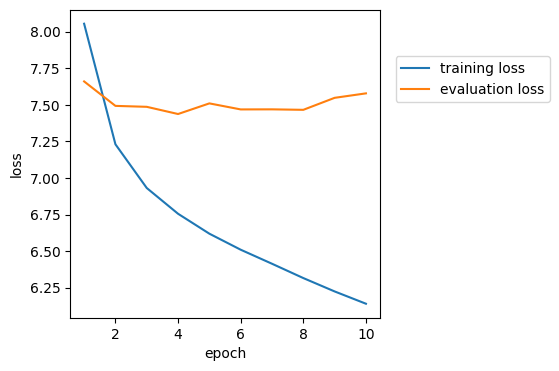

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.plot(df['epoch'], df['train_losses'], label='training loss')
plt.plot(df['epoch'], df['val_losses'], label='evaluation loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(loc=[1.05, 0.7])
plt.show()

# Inference

Now that we have the model trained, we can use it to decode and generate translation.

I did not change the logics behind PyTorch's tutorial codes, only adapting them to our scenarios, especially in the <code>translate</code> function.

In [14]:
# I do not have a GPU machine, so I need to use map_location parameter.

model = torch.load('model_colab', map_location=torch.device('cpu'))

In [48]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, max_len, start_symbol):
    src = src.to(DEVICE)
    memory = model.encode(src)
    
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (Transformer.generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)  # last output vector
        out = out.transpose(0, 1)  # adjust batching
        prob = model.generator(out[:, -1])  # softmax layer, return probability distribution
        _, next_word = torch.max(prob, dim=1)  # get the Tensor containing the token_id with highest probability
        next_word = next_word.item()  # convert Tensor to int

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src: str):
    model.eval()
    
    src = src_vocab(src_tokenizer.encode(src, out_type=str))
    src = torch.cat((torch.tensor([BOS_IDX]),
                     torch.tensor(src),
                     torch.tensor([EOS_IDX]))).view(-1, 1)
    print(src)
    
    num_tokens = src.shape[0]
    
    tgt = greedy_decode(model, src, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    print(tgt)
    tgt = tgt_vocab.lookup_tokens(list(tgt.cpu().numpy()))
    tgt = tgt_tokenizer.decode(tgt).replace("<bos>", "").replace("<eos>", "").strip()
    
    return tgt

The output is still gibberish considering the training data volume and only 10 epochs of train.

But hey! It's been a long journey and it really works!

In [47]:
translate(model, 'this is a simple test.')

tensor([[   2],
        [  29],
        [  18],
        [  11],
        [1120],
        [ 785],
        [   6],
        [   3]])
tensor([ 2,  6,  8, 32, 75,  4,  3])


'1K我们,'